In [1]:
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, roc_curve, auc
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import shap
from keras.layers import Input, Dense, Flatten, \
    Concatenate, concatenate, Dropout, Lambda
from keras.models import Model, Sequential
from keras.layers.embeddings import Embedding
import keras
from livelossplot import PlotLossesKeras
import eli5
from eli5.sklearn import PermutationImportance
import scipy
from scipy.cluster import hierarchy as hc
from lime.lime_tabular import LimeTabularExplainer
import math
import xai
import alibi

params = {
          'font.size': '20.0',
          'figure.figsize': [20, 7],
#           "ytick.color" : "w",
#           "xtick.color" : "w",
#           "text.color": "white",
#           'figure.facecolor': "#384151",
#           'legend.facecolor': "#384151",
#           "axes.labelcolor" : "w",
#           "axes.edgecolor" : "w"
    }

plt.rcParams.update(params)


shap.initjs()


label_column = "loan"
csv_path = 'data/adult.data'
csv_columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country", "loan"]
input_columns = ["age", "workclass", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country"]
categorical_features = ["workclass", "education", "marital-status",
                       "occupation", "relationship", "ethnicity", "gender",
                       "native-country"]

def prepare_data(df):
    
    if "fnlwgt" in df: del df["fnlwgt"]
    
    tmp_df = df.copy()

    # normalize data (this is important for model convergence)
    dtypes = list(zip(tmp_df.dtypes.index, map(str, tmp_df.dtypes)))
    for k,dtype in dtypes:
        if dtype == "int64":
            tmp_df[k] = tmp_df[k].astype(np.float32)
            tmp_df[k] -= tmp_df[k].mean()
            tmp_df[k] /= tmp_df[k].std()

    cat_columns = tmp_df.select_dtypes(['object']).columns
    tmp_df[cat_columns] = tmp_df[cat_columns].astype('category')
    tmp_df[cat_columns] = tmp_df[cat_columns].apply(lambda x: x.cat.codes)
    tmp_df[cat_columns] = tmp_df[cat_columns].astype('int8')
    
    return tmp_df

def get_dataset_1():
    tmp_df = df.copy()
    tmp_df = tmp_df.groupby('loan') \
                .apply(lambda x: x.sample(100) if x["loan"].iloc[0] else x.sample(7_900)) \
                .reset_index(drop=True)
    
    X = tmp_df.drop(label_column, axis=1).copy()
    y = tmp_df[label_column].astype(int).values.copy()
    
    return tmp_df, df_display.copy()

def get_production_dataset():
    tmp_df = df.copy()
    tmp_df = tmp_df.groupby('loan') \
                .apply(lambda x: x.sample(50) if x["loan"].iloc[0] else x.sample(60)) \
                .reset_index(drop=True)
    
    X = tmp_df.drop(label_column, axis=1).copy()
    y = tmp_df[label_column].astype(int).values.copy()
    
    return X, y


def get_dataset_2():
    tmp_df = df.copy()
    tmp_df_display = df_display.copy()
#     tmp_df_display[label_column] = tmp_df_display[label_column].astype(int).values
    
    X = tmp_df.drop(label_column, axis=1).copy()
    y = tmp_df[label_column].astype(int).values.copy()
    
    X_display = tmp_df_display.drop(label_column, axis=1).copy()
    y_display = tmp_df_display[label_column].astype(int).values.copy()
    
    X_train, X_valid, y_train, y_valid = \
        train_test_split(X, y, test_size=0.2, random_state=7)

    return X, y, X_train, X_valid, y_train, y_valid, X_display, y_display, tmp_df, tmp_df_display
    
df_display = pd.read_csv(csv_path, names=csv_columns)
df_display[label_column] = df_display[label_column].apply(lambda x: ">50K" in x)
df = prepare_data(df_display)

def build_model(X):
    input_els = []
    encoded_els = []
    dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
    for k,dtype in dtypes:
        input_els.append(Input(shape=(1,)))
        if dtype == "int8":
            e = Flatten()(Embedding(df[k].max()+1, 1)(input_els[-1]))
        else:
            e = input_els[-1]
        encoded_els.append(e)
    encoded_els = concatenate(encoded_els)

    layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
    out = Dense(1, activation='sigmoid')(layer1)

    # train model
    model = Model(inputs=input_els, outputs=[out])
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
    return model

def f_in(X, m=None):
    """Preprocess input so it can be provided to a function"""
    if m:
        return [X.iloc[:m,i] for i in range(X.shape[1])]
    else:
        return [X.iloc[:,i] for i in range(X.shape[1])]

def f_out(probs):
    """Convert probabilities into classes"""
    return list((probs >= 0.5).astype(int).T[0])

def plot_roc(y, probs):
    
    fpr, tpr, _ = roc_curve(y, probs)

    roc_auc = auc(fpr, tpr)
    print(roc_auc)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (area = %0.2f)' % roc_auc)
    plt.legend(loc="lower right")
    plt.rcParams.update(params)
    plt.show()
    
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in list(np.logspace(0.6,4,dtype='int')):
        if m >= len(X_train): break
        model.fit(f_in(X_train,m), y_train[:m], epochs=50, batch_size=512, verbose=0)
        y_train_predict = model.predict(f_in(X_train,m))
        y_val_predict = model.predict(f_in(X_val))
        y_train_predict = f_out(y_train_predict)
        y_val_predict = f_out(y_val_predict)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    
def keras_score(self, X, y, **kwargs):
    """ Scorer class for eli5 library on feature importance"""
    input_test = [X[:,i] for i in range(X.shape[1])]
    loss = self.evaluate(input_test, y)
    if type(loss) is list:
        # The first one is the error, the rest are metrics
        return -loss[0]
    return -loss

class ModelWrapper():
    """ Keras model wrapper to override the predict function"""
    def __init__(self, model):
        self.model = model
    
    def predict(self, X, **kwargs):
        return self.model.predict([X.iloc[:,i] for i in range(X.shape[1])])

def plot_all_features(X, plot_numeric=True, hist=True, dropna=False):
    fig = plt.figure(figsize=(20,15))
    cols = 5
    rows = math.ceil(float(X.shape[1]) / cols)
    for i, column in enumerate(X.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if X.dtypes[column] == np.object:
            X[column].value_counts().plot(kind="bar", axes=ax)
        elif plot_numeric:
            if hist:
                X[column].hist(axes=ax)
                plt.xticks(rotation="vertical")
            else:
                if dropna:
                    X[column].dropna().plot()
                else:
                    X[column].plot()
                    
    plt.subplots_adjust(hspace=0.7, wspace=0.2)
    
def plot_dendogram(corr, X):
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method="average")
    fig = plt.figure(figsize=(16,5))
    dendrogram = hc.dendrogram(
        z, labels=X.columns, orientation="left", leaf_font_size=16)
    plt.show()
    
def shap_predict(X):
    values = model.predict([X[:,i] for i in range(X.shape[1])]).flatten()
    return values

def lime_predict_proba(X):
    values = model.predict([X[:,i] for i in range(X.shape[1])]).flatten()
    prob_pairs = np.array([1-values, values]).T
    return prob_pairs    


import alibi
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

alibi_data, alibi_labels, alibi_feature_names, alibi_category_map = alibi.datasets.adult()

def get_alibi_data():
    
    # define train and test set
    np.random.seed(0)
    data_perm = np.random.permutation(np.c_[alibi_data, alibi_labels])
    data = data_perm[:, :-1]
    labels = data_perm[:, -1]

    idx = 30000
    X_train, y_train = data[:idx, :], labels[:idx]
    X_test, y_test = data[idx + 1:, :], labels[idx + 1:]

    # feature transformation pipeline
    ordinal_features = [x for x in range(len(alibi_feature_names)) if x not in list(alibi_category_map.keys())]
    ordinal_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                          ('scaler', StandardScaler())])

    categorical_features = list(alibi_category_map.keys())
    categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                              ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(transformers=[('num', ordinal_transformer, ordinal_features),
                                                   ('cat', categorical_transformer, categorical_features)])


    np.random.seed(0)
    clf = RandomForestClassifier(n_estimators=50)

    alibi_loan_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('clf', clf)])

    alibi_loan_model.fit(X_train, y_train)
    
    return X_train, X_test, y_train, y_test, \
        alibi_category_map, alibi_feature_names, alibi_loan_model


ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

Using TensorFlow backend.


/home/alejandro/miniconda3/envs/reddit-classification/lib/python3.7/site-packages/alibi/datasets.py:128: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  raw_data = pd.read_csv(dataset_url, names=raw_features, delimiter=', ').fillna('?')


# A practical guide towards explainability
# and bias evaluation in machine learning

<br>
<br>
<br>
<br>
<br>

<br>

<br>

<br>
<br>

<h2>Alejandro Saucedo</h2>
<br>
Chief Scientist, The Institute for Ethical AI & Machine Learning
<br>
Director of ML Engineering, Seldon Technologies

<br>

<br><br><br>

<hr>


# Today

<br>
<br>

## 1) Hands on example: Company "Hype-ML" automating loan approval process 

<br>
<br>

## 2) Terminology + why it's not about "just removing bias"

<br>
<br>

## 3) XAI - A practical framework to mitigate (not fully remove) bias

<br>
<br>

## 4) Applying the XAI framework to our example

<br>

<br><br><br>

<hr>

# Alibi - Black Box Model Explanations

<br>

## A set of proven scientific techniques to explain ML models as black boxes

<br>

<img src="images/alibi-repo.jpg" style="width=100vw">

<br>

## https://github.com/SeldonIO/Alibi


<br><br><br>

<hr>

# XAI - eXplainable AI 

<br>

## A set of tools to explain machine learning data

<br>

<img src="images/xai.png" style="width=100vw">

<br>

## https://github.com/EthicalML/XAI


<br><br><br>

<hr>

# Hype-ML - A NEW Project has come in!

<br>

* Insurance company has a process where domain expert approves/rejects loan applications

<br>

* They receive over 1m applications and want to automate the process

<br>

# Business wants it NOW!

<br>

* They heard their competitor is using "Machine Learning" and business says we need to use that



<br><br><br>

<hr>

# The team had a look at how this worked

<br>

<img src="images/mlall.png" style="width:70vw">



<br><br><br>

<hr>

# The team asked for DATA

<br>
<br>

## Business gave them an excel sheet with 25 rows

<br>
<br>

The team pushed back, and after a while they finally got a dataset with ~8000 rows




<br><br><br>

<hr>

<br><br><br>


# And so it begun...

<br>

<img src="images/copypasta.jpg" style="height:50vh">

<br>
<br>

## The Hype-ML journey towards greatness...

<br><br><br>

<hr>

<br><br><br>

In [3]:
df_data, df_display = get_dataset_1()

df_display.head()


,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country,loan
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,False
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,False
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,False
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,False
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,False


In [4]:
X = df_data.drop(label_column, axis=1).copy()
y = df_data[label_column].astype(int).values.copy()

X_train, X_valid, y_train, y_valid = \
        train_test_split(X, y, test_size=0.2, random_state=7)

print("Training size:", y_train.shape, "Testing size: ", y_valid.shape)

Training size: (6400,) Testing size:  (1600,)



<img src="images/train-test.png" style="width:70vw">

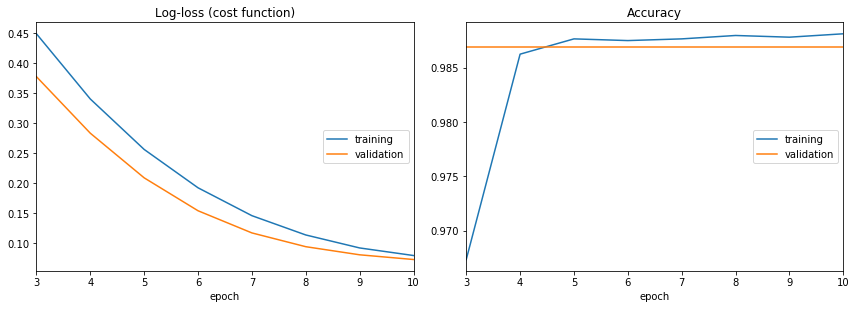

Log-loss (cost function):
training   (min:    0.080, max:    0.738, cur:    0.080)
validation (min:    0.073, max:    0.635, cur:    0.073)

Accuracy:
training   (min:    0.481, max:    0.988, cur:    0.988)
validation (min:    0.859, max:    0.987, cur:    0.987)


In [5]:
# 1 layer, 100 neurons model, with softmax (0-1 probabilities)
model = build_model(X)

model.fit(f_in(X_train), y_train, epochs=10,
    batch_size=512, shuffle=True, validation_data=(f_in(X_valid), y_valid),
    callbacks=[PlotLossesKeras()], verbose=0, validation_split=0.05,)

In [6]:
score = model.evaluate(f_in(X_valid), y_valid, verbose=1)
print("Error %.4f: " % score[0])
print("Accuracy %.4f: " % (score[1]*100))

1600/1600 [==============================] - 0s 47us/step
Error 0.0732: 
Accuracy 98.6875: 


# Accuracy is ~98%!

<br>
<br>
<br>
<br>

### What a better result on a Friday evening!

<br>
<br>
<br>

# Time for PROD?


<br><br><br>

<hr>

<br><br><br>


# We push to PROD!

<br>
<br>
<br>
<br>

### A few weeks go by...

<br>


<br><br><br>

<hr>

<br><br><br>


# BUZZFEED NEWS: HYPE-ML DEPLOYS RACIST SEXIST AI!!!!

<br>

<img src="images/layer.jpg" style="height: 50vh">


<br>


# ...but... but we followed the instructions in the internet!


<br><br><br>

<hr>

<br><br><br>


# Time to diagnose!

<br>
<br>

## We ask business to gather the 110 applications in production...

<br>
<br>

## ...and label it to understand what went wrong


<br><br><br>

<hr>

<br><br><br>

In [7]:
X_prod, y_prod = get_production_dataset()

print(X_prod.shape)
X_prod.head()

(110, 13)


,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country
0,-1.362248,0,15,-0.031359,4,0,3,4,0,-0.145918,-0.216656,-0.035429,39
1,-1.435559,4,15,-0.031359,4,12,3,4,1,-0.145918,-0.216656,-0.440371,39
2,1.863457,6,5,-2.363521,2,3,0,4,1,-0.145918,-0.216656,-1.655199,39
3,-1.435559,4,15,-0.031359,4,1,3,4,0,-0.145918,-0.216656,-0.035429,39
4,-0.922379,7,9,1.134722,4,1,1,4,0,-0.145918,-0.216656,3.204112,39


In [8]:
score = model.evaluate(f_in(X_prod), y_prod, verbose=1)
probabilities = model.predict(f_in(X_prod))
pred = f_out(probabilities)
print("Accuracy %.4f: " % (score[1]*100))

110/110 [==============================] - 0s 102us/step
Accuracy 55.4545: 


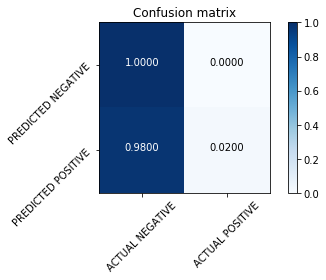

In [9]:
xai.confusion_matrix_plot(y_prod, pred)

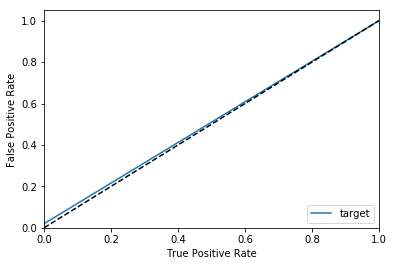

([array([0., 0., 1.]), array([0.  , 0.02, 1.  ])],
 [array([0., 0., 1.]), array([0.  , 0.02, 1.  ])])

In [10]:
xai.roc_plot(y_prod, pred)

[Text(0, 0, 'Rejected'), Text(0, 0, 'Approved')]

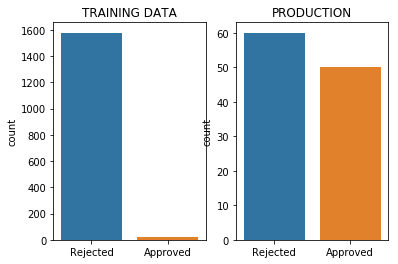

In [11]:
fig, ax = plt.subplots(1,2)
a = sn.countplot(y_valid, ax=ax[0]); a.set_title("TRAINING DATA"); a.set_xticklabels(["Rejected", "Approved"])
a = sn.countplot(y_prod, ax=ax[1]); a.set_title("PRODUCTION"); a.set_xticklabels(["Rejected", "Approved"])

# Undesired bias and explainability

<br>

* Has become popular due to several high profile incidents:

    * Amazon's "sexist" recruitment tool
    * Microsoft's "racist" chatbot
    * Negative discrimination in automated sentencing
    * Black box models with complex patterns that can't be interpretable

<br>
<br>

## Organisations cannot take on unknown risks

<br><br><br>

<hr>

<br><br><br>

# This challenge goes beyond the algorithms

<br>

### A large ethical decision should not just fall on the shoulders of a single data scientist

<br>

<img src="images/chart.png" style="height:30vw;margin-left: 10vw; float: left; background-color: transparent">
<img src="images/chart-more.png" style="height:30vw; margin-left: 10vw; float: left;  background-color: transparent">

<br><br><br>

<hr>

<br><br><br>

# The answer is not just about "removing bias"

<br>
<br>

* Any non trivial decision (i.e. more than 1 option) holds a bias, without exceptions.
* It's impossible to "just remove bias", as the whole purpose of ML is to discriminate towards the right answer
* Societal bias carries an inherent bias - what may be "racist" for one person, may not be for another group or geography

<br>
<br>

## Let's see what "undesired bias" looks like

<br><br><br>

<hr>

<br><br><br>

# Split into two conceptual pieces

<br>
<br>

## 1) Statistical (A-posteriori) bias 

##### The "error" between from where you are to where you CAN be.

<br>
<br>

## 2) A-priori bias 

##### The "error" between where you CAN be to where you SHOULD be.

# Visualising these two types of bias

![](images/bias5.jpg)

# Errors in project decisions (Bias a-posteriori)

<br>

## Sub-optimal choices of accuracy metrics / cost functions

<br>

## Sub-optimal machine learning models chosen for the task 

<br>

## Lack of infrastructure or metrics required to monitor model performance in production

<br>

## Lack of human-in-the-loop where necessary

<br>

## Not using resources at disposal (e.g. domain experts, tools, etc).

<br><br><br>

<hr>

<br><br><br>

# Societal bias (Bias a-priori)

<br>

## Sub-optimal business objectives

<br>

## Lack of understanding of the project 

<br>

## Incomplete resources (data, time, domain experts, etc)

<br>

## Incorrectly labelled data (accident vs otherwise)

<br>

## Lack of relevant skillset

<br>

## Societal shifts in perception

<br><br><br>

<hr>

<br><br><br>

# Explainability is key

<br>
<br>

* To assess whether you have bias

<br>

* For compliance of processes

<br>

* For definitions of regulation (GDPR)

<br>

* To identify and reduce risks (FP vs FN)

# Key Point: Explainability !== Interpretability

<br>

*  Having a model that can be interpreted doesn't mean it can be explained

<br>

* Explainability requires us to go beyond the algorithms

<br>

* Undesired bias cannot be tackled without explainability


<br><br><br>

<hr>

<br><br><br>

# Tackling undesired bias through tools and humans

<br>

## Focusing on process and best practices

* In cybersecurity it's impossible to avoid all hacking attacks, but best practices help mitigate
* Similarly, it's impossible to avoid all undesired bias, but it's possible to mitigate by having the right experts at the right touchpoints

<br>

## Using the right tools with the right domain experts

* There are numerous techniques at the disposal of data scientists to analyse datasets and evaluate models
* These should be use in conjunction with domain experts to understand explanatory/predictive modelling

<br>

## Ensure humans are leveraged

* In some use-cases the level of scrutiny is higher due to the critical nature of the project
* In those cases, the level of human review may be higher, and it may be necessary to have human-in-the-loop processes

<br>


<br><br><br>

<hr>

<br><br><br>

# Remember our workflow? Let's add three new steps:

<br>

<img src="images/mlall.png" style="width=100vw">

# Mitigating undesired bias through three steps

<br>

## 1) Data analysis

* Class imbalances
* Protected features
* Correlations
* Data representability

<br>

## 2) Model Evaluation

* Feature importance analysis
* Model specific explainability methods
* Domain knowledge abstraction 
* Model metrics analysis


<br>

## 3) Production monitoring

* Thresholds set for evaluation metrics 
* Manual human review on critical decisions 
* Monitoring of anomalies and out-of-range predictions


<br><br><br>

<hr>

<br><br><br>

# Augmenting the data science workflow

<br>

<img src="images/gml.png" style="width=100vw">


<br><br><br>

<hr>

<br><br><br>

# The Explainability Tradeoff

<br>

## Introducing fail-safe mechanisms, removing features, and using simpler models may have an impact on accuracy

<br>

## Not all usecases demand the same level of scrutiny

<br>

## The ones that are more critical do require a more strict process

<br>

## Similar to enterprise software, the overhead to offer accountability and governance is introduced


<br><br><br>

<hr>

<br><br><br>


# Many tools available


<br>

* Alibi - Seldon's open source framework for model evaluation and monitoring

<br>

* XAI - eXplainableAI - An eXplainability toolbox for machine learning.

<br>

* SHAP - SHapley Additive exPlanations is a unified approach to explain the output of any machine learning model.

<br>

* LIME - Local Interpretable Model-agnostic Explanations for machine learning models.

<br>

* ELI5 - "Explain Like I'm 5" is a Python package which helps to debug machine learning classifiers and explain their predictions.

<br>
<br>
<br>


## More tools at our "Awesome MLOps List" 

https://github.com/EthicalML/awesome-machine-learning-operations


<br><br><br>

<hr>

<br><br><br>

# 1) Data Analysis

<br><br><br>

<hr>

<br><br><br>

# Points to cover

1.1) Data imbalances

1.2) Upsampling / downsampling

1.3) Correlations

1.4) Train / test set

1.5) Further techniques

In [12]:
X, y, X_train, X_valid, y_train, y_valid, X_display, y_display, df, df_display \
    = get_dataset_2()
df_display.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country,loan
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,False
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,False
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,False
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,False
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,False


## 1.1) Data imbalances

       'relationship', 'ethnicity', 'gender', 'native-country', 'loan'],
      dtype='object'). If you see an error these are not correct, please provide them as a string array as: categorical_cols=['col1', 'col2', ...]


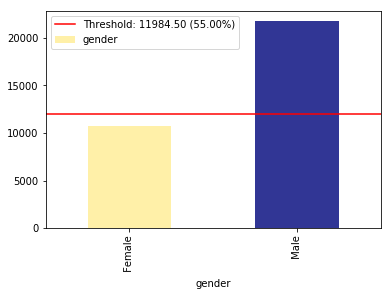

In [13]:
im = xai.imbalance_plot(df_display, "gender", threshold=0.55)

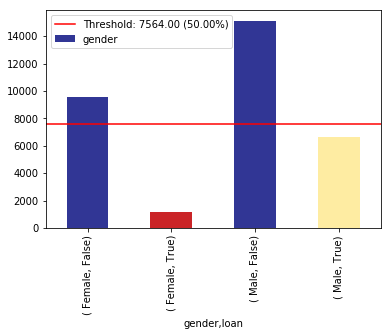

In [14]:
im = xai.imbalance_plot(df_display, "gender", "loan" , categorical_cols=["loan", "gender"])

## 1.2) Upsampling / Downsampling

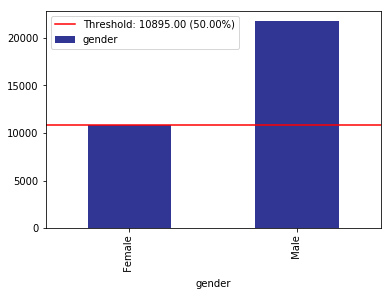

In [37]:
im = xai.balance(df_display, "gender", categorical_cols=["gender"],
                upsample=0.5, bins=5)

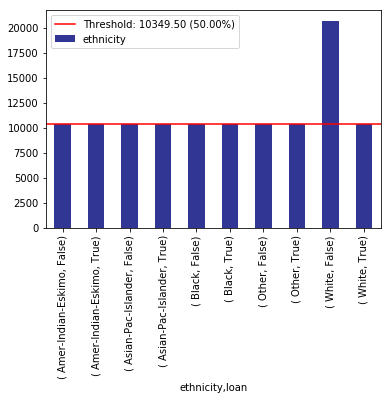

In [42]:
im = xai.balance(df_display, "ethnicity", "loan", categorical_cols=["ethnicity", "loan"],
                upsample=0.5, bins=5)

## 1.3 Correlations hidden in data

/home/alejandro/miniconda3/envs/reddit-classification/lib/python3.7/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


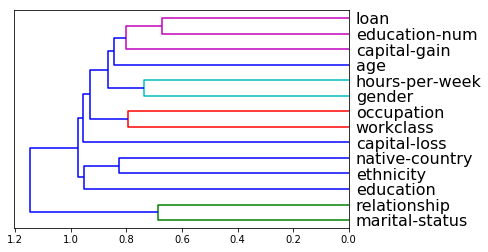

In [43]:
corr = xai.correlations(df_display, include_categorical=True)

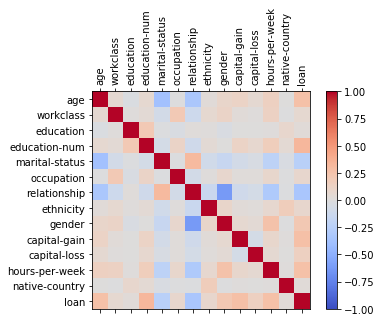

In [44]:
corr = xai.correlations(df_display, include_categorical=True, plot_type="matrix")

## 1.4) Balanced train/testing sets

In [70]:
??xai.balanced_train_test_split

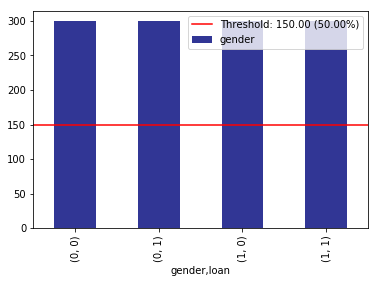

In [73]:
X_train_balanced, y_train_balanced, X_valid_balanced, y_valid_balanced, train_idx, test_idx = \
    xai.balanced_train_test_split(
            X, y, "gender", 
            min_per_group=300,
            max_per_group=300,
            categorical_cols=["gender", "loan"])

X_valid_balanced["loan"] = y_valid_balanced
im = xai.imbalance_plot(X_valid_balanced, "gender", "loan", categorical_cols=["gender", "loan"])

## 1.5 Shoutout to other tools and techniques

# 2) Model evaluation

<br><br><br>

<hr>

<br><br><br>

## Points to cover

2.1) Standard model evaluation metrics

2.2) Global model explanation techniques

2.3) Black box local model explanation techniques

2.4) Other libraries available

# Model Evaluation Metrics: White / Black Box

![](images/whiteblackbox.jpg)

# Model Evaluation Metrics: Global vs Local

![](images/globallocal.jpg)

## 2.1) Standard model evaluation metrics

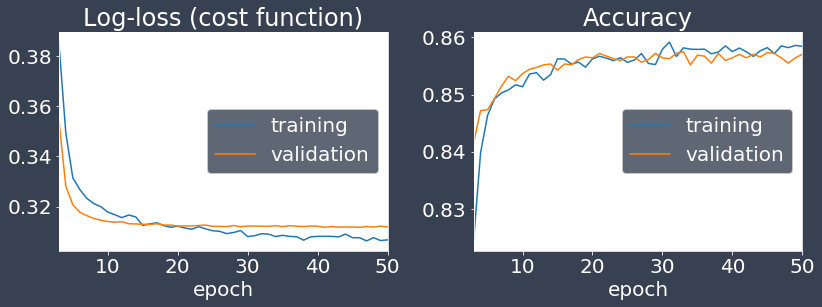

Log-loss (cost function):
training   (min:    0.306, max:    0.589, cur:    0.307)
validation (min:    0.312, max:    0.473, cur:    0.312)

Accuracy:
training   (min:    0.710, max:    0.859, cur:    0.858)
validation (min:    0.800, max:    0.858, cur:    0.857)


In [76]:
# Let's start by building our model with our newly balanced dataset
model = build_model(X)
model.fit(f_in(X_train), y_train, epochs=50, batch_size=512, shuffle=True, validation_data=(f_in(X_valid), y_valid), callbacks=[PlotLossesKeras()], verbose=0, validation_split=0.05,)
probabilities = model.predict(f_in(X_valid))
pred = f_out(probabilities)

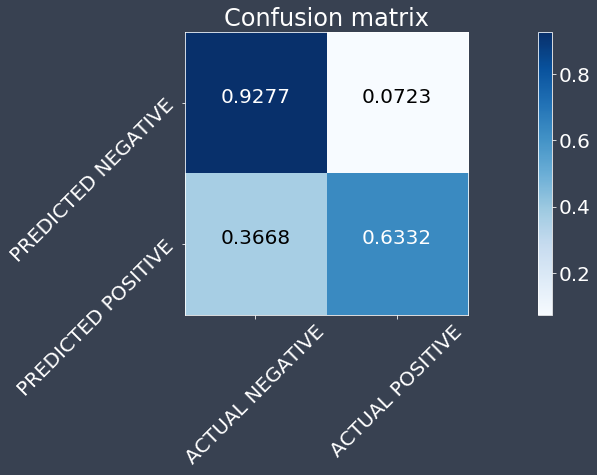

In [77]:
xai.confusion_matrix_plot(y_valid, pred)

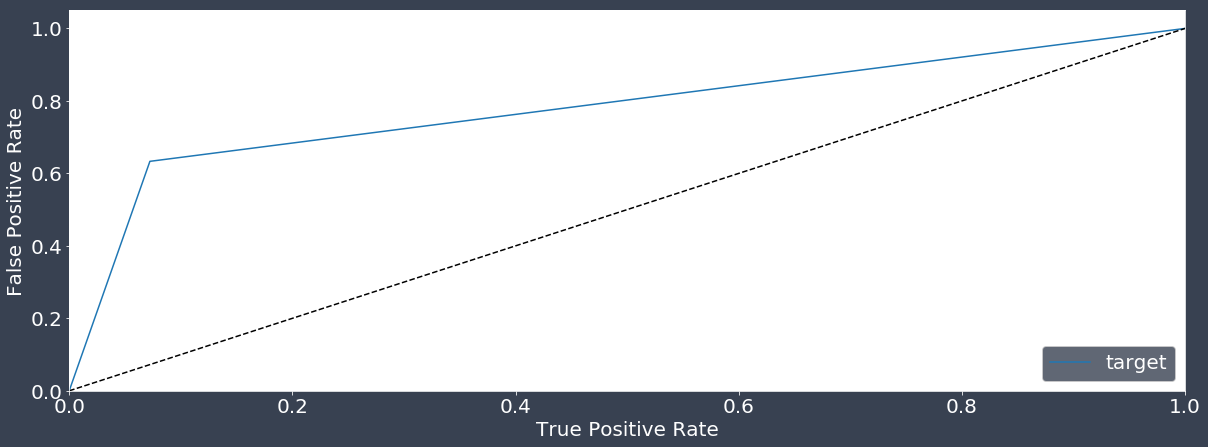

In [78]:
im = xai.roc_plot(y_valid, pred)

In [88]:
# ??xai.precision_recall_curve
im = xai.(y_valid, pred)

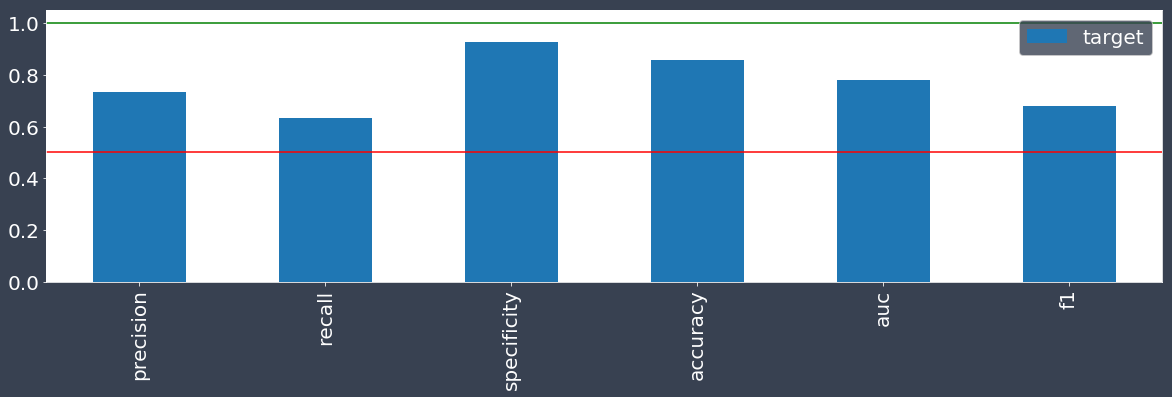

In [80]:
im = xai.metrics_plot(y_valid, pred)

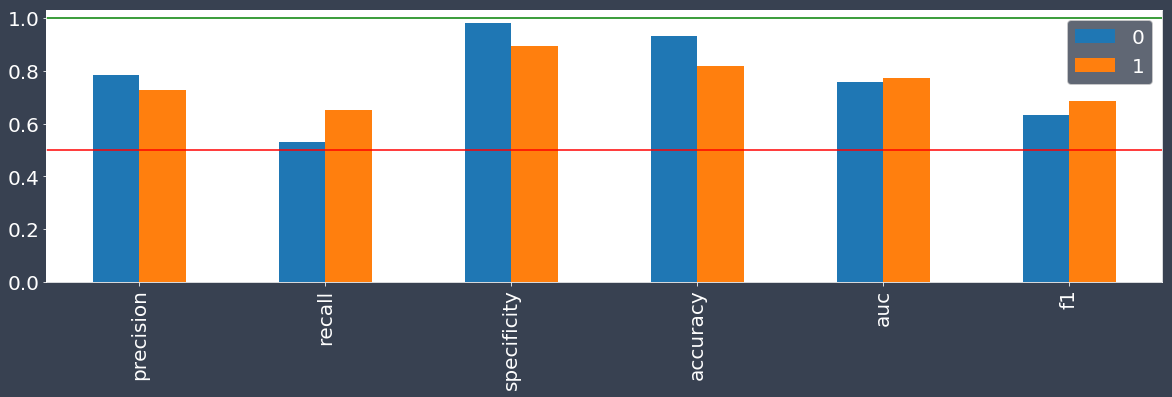

In [81]:
im = xai.metrics_plot(y_valid, pred, X_valid, cross_cols=["gender"], categorical_cols="gender")

# 2.2) Global black box model evalutaion metrics

/home/alejandro/miniconda3/envs/reddit-classification/lib/python3.7/site-packages/xai/__init__.py:1127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  x[c] = tmp


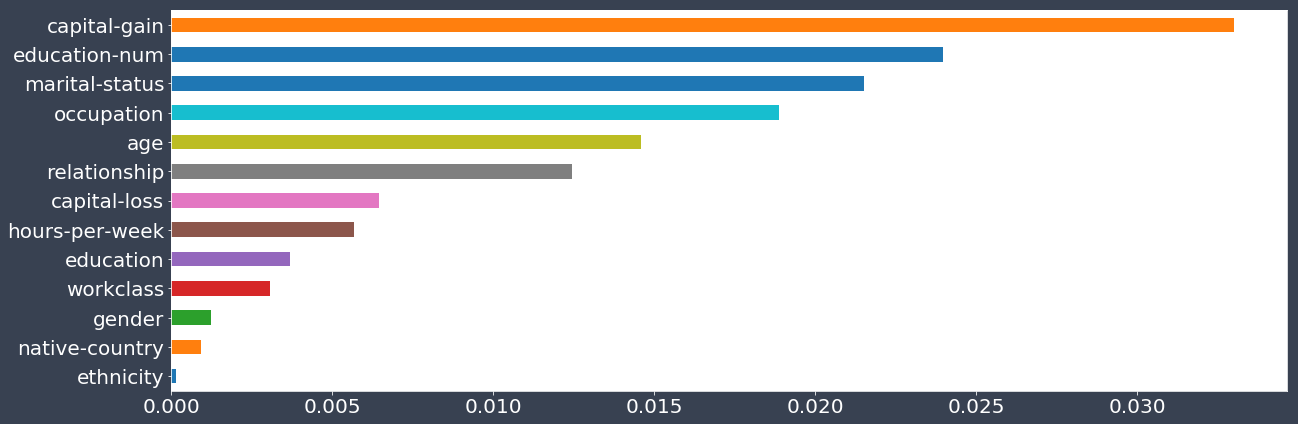

In [89]:
imp = xai.feature_importance(X_valid, y_valid, lambda x, y: model.evaluate(f_in(x), y, verbose=0)[1], repeat=1)

# 2.3) Local black box model evaluation metrics
### Overview of methods

![](images/alibi-table.jpg)

# Anchors 

<br>

#### Consists of if-then rules, called the anchors, which sufficiently guarantee the explanation locally and try to maximize the area for which the explanation holds. (ArXiv: Anchors: High-Precision Model-Agnostic Explanations)

<br>

<div style="float: left; width: 50%">
<img src="images/textanchor.jpg">
</div>

<div style="float: left; width: 50%">
<img src="images/anchorimage.jpg">
</div>

In [90]:
X_train_alibi, X_test_alibi, y_train_alibi, y_test_alibi, \
    category_map_alibi, feature_names_alibi, loan_model_alibi = get_alibi_data()

In [91]:
from alibi.explainers import AnchorTabular

explainer = AnchorTabular(
    loan_model_alibi.predict, 
    feature_names_alibi, 
    categorical_names=category_map_alibi)

explainer.fit(
    X_train_alibi, 
    disc_perc=[25, 50, 75])

In [95]:
explanation = explainer.explain(X_test_alibi[:1], threshold=0.95)

print('Anchor: %s' % (' AND '.join(explanation['names'])))
print('Precision: %.2f' % explanation['precision'])
print('Coverage: %.2f' % explanation['coverage'])

Anchor: Marital Status = Separated AND Sex = Female
Precision: 0.96
Coverage: 0.11


# Counterfactual Explanations

### The counterfactual explanation of an outcome or a situation Y takes the form “If X had not occured, Y would not have occured” 

![](images/counterfactuals7.jpg)

## 1.5 Shoutout to other tools and techniques

# 3) Production Monitoring

<br><br><br>

<hr>

<br><br><br>

# Key points to cover

<br>

1) Challenges of reproducibility in production monitoring

<br>

2) Design patterns for explainers

<br>

3) Live demo of explainers

<br>

4) Leveraging humans for explainers

## 3.1) Challenges of production monitoring

When deploying a model in production, end-to-end explainability has a lot of challenges

## Reproducibility per component

![](images/abstracting-steps.jpg)

## Reproducibility per component

![](images/abstracting-pipeline.jpg)

## Audit trails

![](images/audit-trail.jpg)

# A LOT of challenges

<br>

### That's why we compiled them in a list: https://github.com/EthicalML/awesome-machine-learning-operations

![](images/mlops-list.jpg)


# 3.2) Design patterns for explainers

![](images/deployment-overview.jpg)

# Deploy the Seldon ML Orchestrator in Kubernetes

In [99]:
!helm install /home/alejandro/Programming/kubernetes/seldon/helm-charts/seldon-core-operator --name seldon-core-operator 

NAME:   seldon-core-operator
LAST DEPLOYED: Wed Jun 19 04:59:42 2019
NAMESPACE: default
STATUS: DEPLOYED

RESOURCES:
==> v1/ClusterRole
NAME                          AGE
seldon-operator-manager-role  1s

==> v1/ClusterRoleBinding
NAME                                 AGE
seldon-operator-manager-rolebinding  1s

==> v1/Pod(related)
NAME                                  READY  STATUS             RESTARTS  AGE
seldon-operator-controller-manager-0  0/1    ContainerCreating  0         0s

==> v1/Secret
NAME                                   TYPE    DATA  AGE
seldon-operator-webhook-server-secret  Opaque  0     1s

==> v1/Service
NAME                                        TYPE       CLUSTER-IP    EXTERNAL-IP  PORT(S)  AGE
seldon-operator-controller-manager-service  ClusterIP  10.98.121.87  <none>       443/TCP  0s

==> v1/StatefulSet
NAME                                READY  AGE
seldon-operator-controller-manager  0/1    0s

==> v1beta1/CustomResourceDefinition
NAME                         

In [100]:
!helm install /home/alejandro/Programming/kubernetes/seldon/helm-charts/seldon-core-analytics --name seldon-core-analytics

NAME:   seldon-core-analytics
LAST DEPLOYED: Wed Jun 19 04:59:57 2019
NAMESPACE: default
STATUS: DEPLOYED

RESOURCES:
==> v1/ConfigMap
NAME                       DATA  AGE
alertmanager-server-conf   1     0s
grafana-import-dashboards  11    0s
prometheus-rules           0     0s
prometheus-server-conf     1     0s

==> v1/Job
NAME                            COMPLETIONS  DURATION  AGE
grafana-prom-import-dashboards  0/1          0s        0s

==> v1/Pod(related)
NAME                                      READY  STATUS             RESTARTS  AGE
alertmanager-deployment-b9c99d4-6rf5c     0/1    ContainerCreating  0         0s
grafana-prom-deployment-687bc94bbb-c28j5  0/1    ContainerCreating  0         0s
grafana-prom-import-dashboards-fk4vl      0/1    ContainerCreating  0         0s
prometheus-deployment-668c446668-rfbrl    0/1    Pending            0         0s
prometheus-node-exporter-sdt7j            0/1    ContainerCreating  0         0s

==> v1/Secret
NAME                 TYPE    DAT

In [103]:
!helm install /home/alejandro/Programming/kubernetes/seldon/helm-charts/charts/stable/ambassador --name ambassador

NAME:   ambassador
LAST DEPLOYED: Wed Jun 19 05:01:21 2019
NAMESPACE: default
STATUS: DEPLOYED

RESOURCES:
==> v1/Deployment
NAME        READY  UP-TO-DATE  AVAILABLE  AGE
ambassador  0/3    3           0          0s

==> v1/Pod(related)
NAME                        READY  STATUS             RESTARTS  AGE
ambassador-c8f5c967c-lhsss  0/1    ContainerCreating  0         0s
ambassador-c8f5c967c-rctpp  0/1    ContainerCreating  0         0s
ambassador-c8f5c967c-tvcrq  0/1    ContainerCreating  0         0s

==> v1/Service
NAME               TYPE          CLUSTER-IP      EXTERNAL-IP  PORT(S)                     AGE
ambassador         LoadBalancer  10.108.196.164  <pending>    80:30209/TCP,443:31506/TCP  0s
ambassador-admins  ClusterIP     10.107.102.11   <none>       8877/TCP                    0s

==> v1/ServiceAccount
NAME        SECRETS  AGE
ambassador  1        0s

==> v1beta1/ClusterRole
NAME        AGE
ambassador  0s

==> v1beta1/ClusterRoleBinding
NAME        AGE
ambassador  0s

==> v1

# Save the binaries of the models in the folder

In [ ]:
import dill

with open("pipeline/pipeline_steps/loanclassifier/preprocessor.dill", "wb") as prep_f:
    dill.dump(preprocessor, prep_f)
    
with open("pipeline/pipeline_steps/loanclassifier/model.dill", "wb") as model_f:
    dill.dump(clf, model_f)

# Build a Model wrapper with a predict function

In [ ]:
%%writefile pipeline/pipeline_steps/loanclassifier/Model.py
import dill

class Model:
    def __init__(self, *args, **kwargs):
        
        with open("preprocessor.dill", "rb") as prep_f:
            self.preprocessor = dill.load(prep_f)
        with open("model.dill", "rb") as model_f:
            self.clf = dill.load(model_f)
        
    def predict(self, X, feature_names=[]):
        X_prep = self.preprocessor.transform(X)
        proba = self.clf.predict_proba(X_prep)
        return proba

# Use the source2image command to containerize code

In [ ]:
!s2i build pipeline/pipeline_steps/loanclassifier seldonio/seldon-core-s2i-python3:0.8 loanclassifier:0.1

# Define the graph of your pipeline with individual models

In [ ]:
%%writefile pipeline/pipeline_steps/loanclassifier/loanclassifiermodel.yaml
apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  labels:
    app: seldon
  name: loanclassifier
spec:
  name: loanclassifier
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: loanclassifier:0.1
          name: model
    graph:
      children: []
      name: model
      type: MODEL
      endpoint:
        type: REST
    name: loanclassifier
    replicas: 1

# Deploy graph definition of your model 

In [104]:
!/home/alejandro/Programming/kubernetes/seldon/seldon-deploy/seldonctl/seldonctl demo income-explainer

2019/06/19 05:06:20 Seldon Core already present in namespace
2019/06/19 05:06:21 Seldon Core Analytics already present in namespace
2019/06/19 05:06:21 Ambassador already present in namespace
2019/06/19 05:06:21 Seldon Income Classifier Example not found - installing
2019/06/19 05:06:21 Seldon income Explainer Demo setup completed


# Visualise metrics and explanations 

![](images/deploy-expl.jpg)

# Leveraging Humans for Explanations



![](images/smile1.jpg)

![](images/smile2.jpg)

![](images/smile3.jpg)

# Revisiting our workflow

<img src="images/gml.png" style="width=100vw">

# Explainability and Bias Evaluation

<br>
<br>
<br>
<br>
<br>
<br>

## Alejandro Saucedo
<br>
Chief Scientist, The Institute for Ethical AI & Machine Learning

<br>
<br>

[github.com/ethicalml/bias-analysis](github.com/ethicalml/bias-analysis)


<br><br><br>

<hr>

<br><br><br>
